# Store Item Demand Forecasting

This data set contains store-item sales data for 5 years. We will try to forecast 3-month sales volume using time series techniques.

## Content
1. [Python Libraries](#1)
2. [Loading Data](#2)
3. [Exploratory Data Analysis](#3)
4. [Feature Engineering](#4)
5. [Time-Based Validation Sets](#5)
6. [Feature Selection](#6)
7. [Model Building](#7)
8. [Hyperparameter Optimization](#8)

<a id="1"></a>
## Python Libraries

In [3]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import optuna

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f'% x)
warnings.filterwarnings("ignore")

<a id="2"></a>
## Loading Data

In [5]:
train = pd.read_csv("train.csv",parse_dates=["date"])
test = pd.read_csv("test.csv",parse_dates=["date"])
sample_sub = pd.read_csv("sample_submission.csv")

In [6]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [7]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [8]:
sample_sub.head()

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


In [9]:
# We will perform data preprocessing and feature extraction operations on all the data.

df = pd.concat([train, test], sort=False)

<a id="3"></a>
## Exploratory Data Analysis

In [11]:
## check function:

def check_df(dataframe, head=5):
    print("############ Shape ############")
    print(dataframe.shape)
    print("############ Types ############")
    print(dataframe.dtypes)
    print("############ Head ############")
    print(dataframe.head(head))
    print("############ Tail ############")
    print(dataframe.tail(head))
    print("############ NA ############")
    print(dataframe.isnull().sum())
    print("############ Quantiles ############")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [12]:
# max and min date in data set:

df["date"].min(), df["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [13]:
## Unique number of stores

df[["store"]].nunique()

store    10
dtype: int64

In [14]:
## Unique number of items

df[["item"]].nunique()

item    50
dtype: int64

In [15]:
## Number of unique values in store product breakdown:

df.groupby("store")["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [27]:
## Sales figures by product breakdown in stores:

df.groupby(["store", "item"]).agg({"sales":"sum"}).head(10)

sales
store item           
1     1     36468.000
      2     97050.000
      3     60638.000
      4     36440.000
      5     30335.000
      6     96889.000
      7     96383.000
      8    126856.000
      9     84918.000
      10   121163.000

In [29]:
## Sales statistics by store product breakdown

df.groupby(["store", "item"]).agg({"sales":["sum","mean","median","std"]}).head()

sales                     
                 sum   mean median    std
store item                               
1     1    36468.000 19.972 19.000  6.741
      2    97050.000 53.149 52.000 15.006
      3    60638.000 33.208 33.000 10.073
      4    36440.000 19.956 20.000  6.641
      5    30335.000 16.613 16.000  5.672

<a id="4"></a>
## Feature Engineering

### Date Features

We will produce date features to obtain information about trends and capture seasonality.

In [32]:
def create_date_features(df, date_col="date"):
    df["month"] = df[date_col].dt.month
    df["day_of_month"] = df[date_col].dt.day
    df["day_of_year"] = df[date_col].dt.dayofyear
    df["week_of_year"] = df[date_col].dt.isocalendar().week.astype(int)
    df["day_of_week"] = df[date_col].dt.weekday
    df["year"] = df[date_col].dt.year
    df["is_wknd"] = (df[date_col].dt.weekday >= 5).astype(int)
    df["is_month_start"] = df[date_col].dt.is_month_start.astype(int)
    df["is_month_end"] = df[date_col].dt.is_month_end.astype(int)
    df['quarter'] = df[date_col].dt.quarter
    df['is_quarter_start'] = df[date_col].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_col].dt.is_quarter_end.astype(int)
    df["is_year_start"] = df[date_col].dt.is_year_start.astype(int)
    df["is_year_end"] = df[date_col].dt.is_year_end.astype(int)
    return df

df = create_date_features(df)

In [33]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,2013-01-01,1,1,13.000,NaN,1,1,1,1,1,2013,0,1,0,1,1,0,1,0
1,2013-01-02,1,1,11.000,NaN,1,2,2,1,2,2013,0,0,0,1,0,0,0,0
2,2013-01-03,1,1,14.000,NaN,1,3,3,1,3,2013,0,0,0,1,0,0,0,0
3,2013-01-04,1,1,13.000,NaN,1,4,4,1,4,2013,0,0,0,1,0,0,0,0
4,2013-01-05,1,1,10.000,NaN,1,5,5,1,5,2013,1,0,0,1,0,0,0,0


In [36]:
# Sales statistics broken down by store, product, and month:

df.groupby(["store", "item","month"]).agg({"sales":["sum","mean","median","std"]}).head(10)

sales                    
                      sum   mean median   std
store item month                             
1     1    1     2125.000 13.710 13.000 4.397
           2     2063.000 14.631 14.000 4.668
           3     2728.000 17.600 17.000 4.545
           4     3118.000 20.787 20.000 4.894
           5     3448.000 22.245 22.000 6.565
           6     3725.000 24.833 24.000 6.231
           7     4025.000 25.968 25.000 6.737
           8     3492.000 22.529 22.000 5.888
           9     3208.000 21.387 20.500 5.797
           10    3045.000 19.645 20.000 5.832

### Lag/Shifted Features

Lag values will be generated using the sales variable. When we generate these values, random noise is added to the dataset to prevent overfitting.

In [39]:
## Random Noise:

def random_noise(dataframe):
    return np.random.normal(scale = 1.6, size = (len(dataframe),))

In [41]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe["sales_lag_" + str(lag)] = dataframe.groupby(["store", "item"])["sales"].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

# Since we want to estimate a 3-month period, we start the delay from 3 months.

df = lag_features(df, [91,92,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,
                       350,351,352,352,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,
                       538,539,540,541,542,
                       718,719,720,721,722])

df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722
0,2013-01-01,1,1,13.000,NaN,1,1,1,1,1,2013,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.000,NaN,1,2,2,1,2,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.000,NaN,1,3,3,1,3,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.000,NaN,1,4,4,1,4,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.000,NaN,1,5,5,1,5,2013,1,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Rolling Mean Features

In [43]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe["sales_roll_mean_" + str(window)] = dataframe.groupby(["store", "item"])["sales"]. \
                                                        transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

df = roll_mean_features(df,[91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720])

df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720
0,2013-01-01,1,1,13.000,NaN,1,1,1,1,1,2013,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.000,NaN,1,2,2,1,2,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.000,NaN,1,3,3,1,3,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.000,NaN,1,4,4,1,4,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.000,NaN,1,5,5,1,5,2013,1,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exponentially Weighted Mean Features

Exponentially weighted averages are added to the data set according to different alpha values.

In [45]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe["sales-ewm_alpha_" + str(alpha).replace(".","") + str(lag)] = \
                dataframe.groupby(["store", "item"])["sales"].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [46]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720]

df = ewm_features(df, alphas, lags)

df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales-ewm_alpha_09591,sales-ewm_alpha_09592,sales-ewm_alpha_095178,sales-ewm_alpha_095179,sales-ewm_alpha_095180,sales-ewm_alpha_095181,sales-ewm_alpha_095182,sales-ewm_alpha_095359,sales-ewm_alpha_095360,sales-ewm_alpha_095361,sales-ewm_alpha_095449,sales-ewm_alpha_095450,sales-ewm_alpha_095451,sales-ewm_alpha_095539,sales-ewm_alpha_095540,sales-ewm_alpha_095541,sales-ewm_alpha_095629,sales-ewm_alpha_095630,sales-ewm_alpha_095631,sales-ewm_alpha_095720,sales-ewm_alpha_0991,sales-ewm_alpha_0992,sales-ewm_alpha_09178,sales-ewm_alpha_09179,sales-ewm_alpha_09180,sales-ewm_alpha_09181,sales-ewm_alpha_09182,sales-ewm_alpha_09359,sales-ewm_alpha_09360,sales-ewm_alpha_09361,sales-ewm_alpha_09449,sales-ewm_alpha_09450,sales-ewm_alpha_09451,sales-ewm_alpha_09539,sales-ewm_alpha_09540,sales-ewm_alpha_09541,sales-ewm_alpha_09629,sales-ewm_alpha_09630,sales-ewm_alpha_09631,sales-ewm_alpha_09720,sales-ewm_alpha_0891,sales-ewm_alpha_0892,sales-ewm_alpha_08178,sales-ewm_alpha_08179,sales-ewm_alpha_08180,sales-ewm_alpha_08181,sales-ewm_alpha_08182,sales-ewm_alpha_08359,sales-ewm_alpha_08360,sales-ewm_alpha_08361,sales-ewm_alpha_08449,sales-ewm_alpha_08450,sales-ewm_alpha_08451,sales-ewm_alpha_08539,sales-ewm_alpha_08540,sales-ewm_alpha_08541,sales-ewm_alpha_08629,sales-ewm_alpha_08630,sales-ewm_alpha_08631,sales-ewm_alpha_08720,sales-ewm_alpha_0791,sales-ewm_alpha_0792,sales-ewm_alpha_07178,sales-ewm_alpha_07179,sales-ewm_alpha_07180,sales-ewm_alpha_07181,sales-ewm_alpha_07182,sales-ewm_alpha_07359,sales-ewm_alpha_07360,sales-ewm_alpha_07361,sales-ewm_alpha_07449,sales-ewm_alpha_07450,sales-ewm_alpha_07451,sales-ewm_alpha_07539,sales-ewm_alpha_07540,sales-ewm_alpha_07541,sales-ewm_alpha_07629,sales-ewm_alpha_07630,sales-ewm_alpha_07631,sales-ewm_alpha_07720,sales-ewm_alpha_0591,sales-ewm_alpha_0592,sales-ewm_alpha_05178,sales-ewm_alpha_05179,sales-ewm_alpha_05180,sales-ewm_alpha_05181,sales-ewm_alpha_05182,sales-ewm_alpha_05359,sales-ewm_alpha_05360,sales-ewm_alpha_05361,sales-ewm_alpha_05449,sales-ewm_alpha_05450,sales-ewm_alpha_05451,sales-ewm_alpha_05539,sales-ewm_alpha_05540,sales-ewm_alpha_05541,sales-ewm_alpha_05629,sales-ewm_alpha_05630,sales-ewm_alpha_05631,sales-ewm_alpha_05720
0,2013-01-01,1,1,13.000,NaN,1,1,1,1,1,2013,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## Special Days Features

In [48]:
def is_black_friday(date):
    if date.month == 11:
        month_days = pd.date_range(start=date.replace(day=1), end=date.replace(day=30))
        fridays = [d for d in month_days if d.weekday() == 4]
        last_friday = fridays[-1]
        return int(date == last_friday)
    return 0

df["is_black_friday"] = df["date"].apply(is_black_friday)

def is_summer_solstice(date):
    return int(date.month == 6 and date.day in [19, 20, 21, 22])

df["is_summer_solstice"] = df["date"].apply(is_summer_solstice)

# Black Week

df["is_black_week"] = df["date"].apply(lambda x: int(x.month == 11 and x.week >= 47))

# Salary Payment Effect

df["is_salary_period"] = df["day_of_month"].between(5, 10).astype(int)

## One-Hot Encoding

In [50]:
df = pd.get_dummies(df, columns=["store","item","day_of_week","month"], dtype=int)

### Log of Dependent Variable

In [52]:
df["sales"] = np.log1p(df["sales"].values)

<a id="5"></a>
## Time-Based Validation Sets

In [54]:
train.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [55]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [56]:
test.tail()

,id,date,store,item
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50
44999,44999,2018-03-31,10,50


In [57]:
# Kaggle expects us to predict the first three months of 2018. We will use the first three months of 2017 as a validation basis.
train = df.loc[(df["date"]< "2017-01-01"), :]
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ["date", "id", "sales", "year"]]

Y_train = train["sales"]
X_train = train[cols]

Y_val = val["sales"]
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 267), (45000,), (45000, 267))

<a id="6"></a>
## Feature Selection

We will build an XGBoost model and examine the significance levels of the variables for that model. We will select the variables that are meaningful to the model.

In [59]:
model_1 = XGBRegressor().fit(X_train, Y_train)

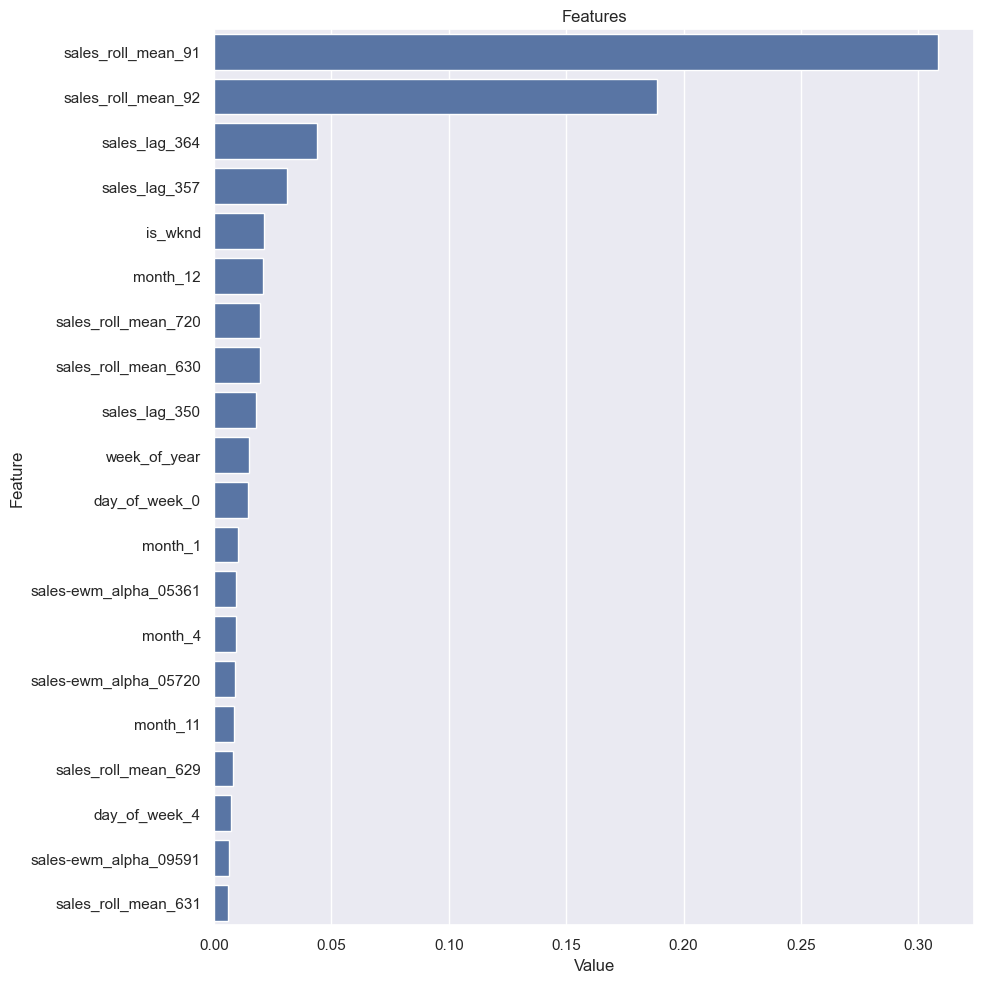

In [60]:
def plot_importance(model, features, num=None, save=False):
    if num is None:
        num = len(features.columns)

    feature_imp = pd.DataFrame({
        "Value": model.feature_importances_,
        "Feature": features.columns
    })

    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)

    sns.barplot(
        x="Value",
        y="Feature",
        data=feature_imp.sort_values(by="Value", ascending=False).head(num)
    )

    plt.title("Features")
    plt.tight_layout()
    plt.show()

    if save:
        plt.savefig("importances.png")

    return feature_imp

feature_imp = plot_importance(model=model_1, features=X_train, num=20)

In [61]:
feature_imp = feature_imp.sort_values(by="Value", ascending = False)
feature_imp.head(10)

,Value,Feature
64,0.308,sales_roll_mean_91
65,0.189,sales_roll_mean_92
47,0.044,sales_lag_364
40,0.031,sales_lag_357
3,0.021,is_wknd
266,0.021,month_12
83,0.020,sales_roll_mean_720
81,0.020,sales_roll_mean_630
34,0.018,sales_lag_350
2,0.015,week_of_year


In [62]:
feature_imp.describe().T

,count,mean,std,min,25%,50%,75%,max
Value,267.000,0.004,0.022,0.000,0.000,0.000,0.002,0.308


In [63]:
X_train_new = X_train[feature_imp[feature_imp["Value"]>=0.002]["Feature"]]
X_val_new = X_val[feature_imp[feature_imp["Value"]>=0.002]["Feature"]]

In [64]:
Y_train.shape, X_train_new.shape, Y_val.shape, X_val_new.shape

((730500,), (730500, 61), (45000,), (45000, 61))

<a id="7"></a>
## Model Building

In [83]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    return mae, rmse

In [85]:
models = {
    "XGBoost Regressor": XGBRegressor(),
    "LGBMRegressor": LGBMRegressor()
}

In [87]:
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train_new, Y_train)

    y_train_pred = model.predict(X_train_new)
    y_val_pred = model.predict(X_val_new)


    model_train_mae, model_train_rmse = evaluate_model(Y_train, y_train_pred)
    model_val_mae, model_val_rmse = evaluate_model(Y_val, y_val_pred)

    print(list(models.keys())[i])
    print("Model performance for Training Set")
    print("Root Mean Squared Error: ", model_train_rmse)
    print("Mean Absolute Error: ", model_train_mae)

    print("---------------------------------")

    print("Model performance for Val Set")
    print("Root Mean Squared Error: ", model_val_mae)
    print("Mean Absolute Error: ", model_val_rmse)

    print("-------------------------------")
    print("\n")

XGBoost Regressor
Model performance for Training Set
Root Mean Squared Error:  0.1668329168997727
Mean Absolute Error:  0.12714587929130622
---------------------------------
Model performance for Val Set
Root Mean Squared Error:  0.13412664294575422
Mean Absolute Error:  0.17689129752213673
-------------------------------




  File "C:\Users\okand\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\okand\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\okand\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\okand\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7504
[LightGBM] [Info] Number of data points in the train set: 730500, number of used features: 61
[LightGBM] [Info] Start training from score 3.789881
LGBMRegressor
Model performance for Training Set
Root Mean Squared Error:  0.16997883191882518
Mean Absolute Error:  0.1293404533094458
---------------------------------
Model performance for Val Set
Root Mean Squared Error:  0.13421504655001693
Mean Absolute Error:  0.1768920363645108
-------------------------------




<a id="8"></a>
## Hyperparameter Optimization

In [89]:
tscv = TimeSeriesSplit(n_splits=3)

def objective(trial):

    params = {
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.05, 0.1, 0.3]),
        "max_depth": trial.suggest_categorical("max_depth", [3,5,7,None]),
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 300, 500, 1000]),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.6, 0.8, 1.0]),
        "subsample": 1.0,          
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "eval_metric": "rmse",
        "random_state": 42,
        "early_stopping_rounds": 50
    }

    fold_rmse = []

    for train_index, valid_index in tscv.split(X_train_new):

        X_train_fold = X_train_new.iloc[train_index]
        y_train_fold = Y_train.iloc[train_index]

        X_valid_fold = X_train_new.iloc[valid_index]
        y_valid_fold = Y_train.iloc[valid_index]

        model = XGBRegressor(**params)

        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_valid_fold, y_valid_fold)],
            verbose=False
        )

        preds = model.predict(X_valid_fold)
        rmse = mean_squared_error(y_valid_fold, preds, squared=False)
        fold_rmse.append(rmse)

    return sum(fold_rmse) / len(fold_rmse)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15, show_progress_bar=True)

print("Best params:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2025-12-11 12:17:45,322] A new study created in memory with name: no-name-4c1759ed-b7f7-4a20-8ba3-36c57ab87500


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-12-11 12:18:48,362] Trial 0 finished with value: 0.17171383303868826 and parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 1.0}. Best is trial 0 with value: 0.17171383303868826.
[I 2025-12-11 12:19:19,292] Trial 1 finished with value: 0.17298455768136403 and parameters: {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 100, 'colsample_bytree': 0.8}. Best is trial 0 with value: 0.17171383303868826.
[I 2025-12-11 12:19:51,528] Trial 2 finished with value: 0.17445540109082625 and parameters: {'learning_rate': 0.05, 'max_depth': None, 'n_estimators': 100, 'colsample_bytree': 1.0}. Best is trial 0 with value: 0.17171383303868826.
[I 2025-12-11 12:21:10,481] Trial 3 finished with value: 0.17279014519982114 and parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 500, 'colsample_bytree': 0.8}. Best is trial 0 with value: 0.17171383303868826.
[I 2025-12-11 12:21:47,846] Trial 4 finished with value: 0.17394187957100163 and 

In [90]:
model = XGBRegressor(**study.best_params).fit(X_train_new, Y_train)

y_pred_val = model.predict(X_val_new)

### Custom Cost Function:

SMAPE: Symetric mean absolute percentage error (adjusted MAPE)

In [92]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num/denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels=train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return "SMAPE", smape_val, False

In [93]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.569489698261627

Our model makes predictions with an average margin of error of 13%.

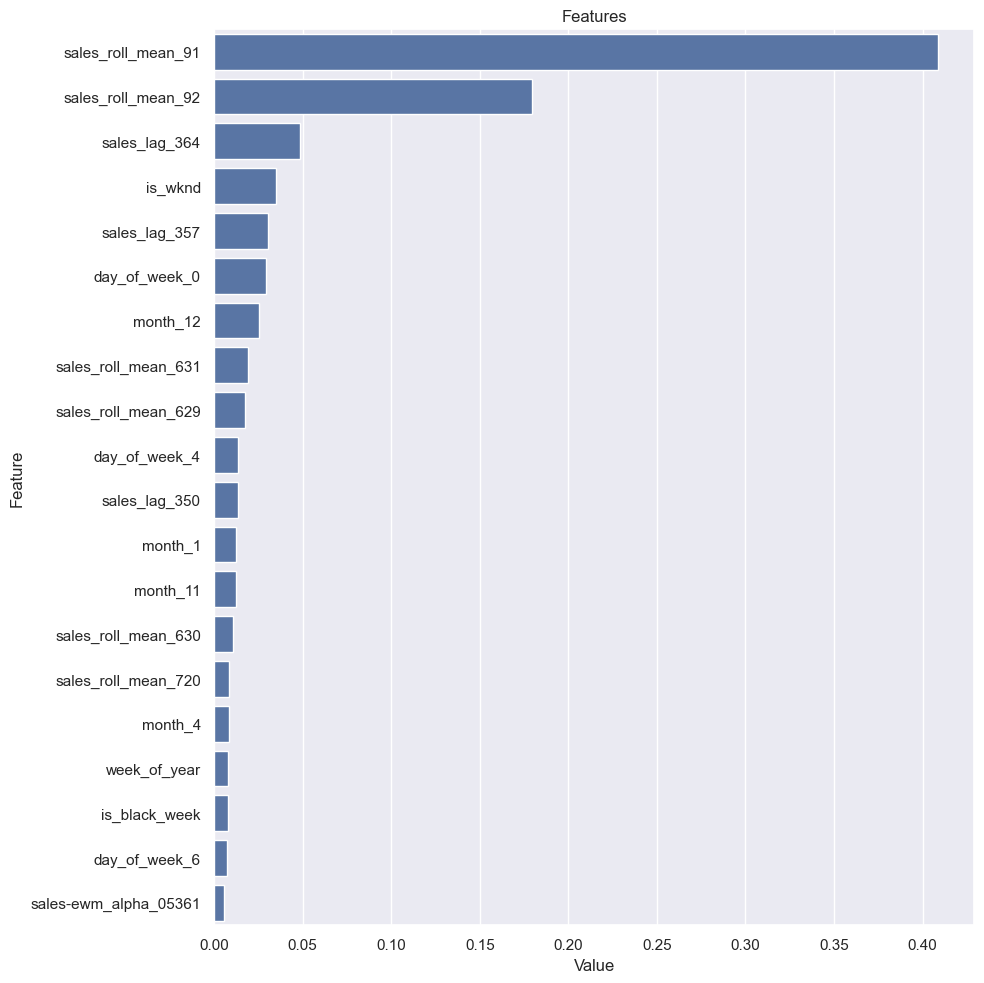

,Value,Feature
0,0.409,sales_roll_mean_91
1,0.179,sales_roll_mean_92
2,0.048,sales_lag_364
3,0.030,sales_lag_357
4,0.035,is_wknd
5,0.025,month_12
6,0.009,sales_roll_mean_720
7,0.011,sales_roll_mean_630
8,0.013,sales_lag_350
9,0.008,week_of_year


In [95]:
# Feature importances

plot_importance(model=model, features=X_train_new, num=20)

### Observing the results

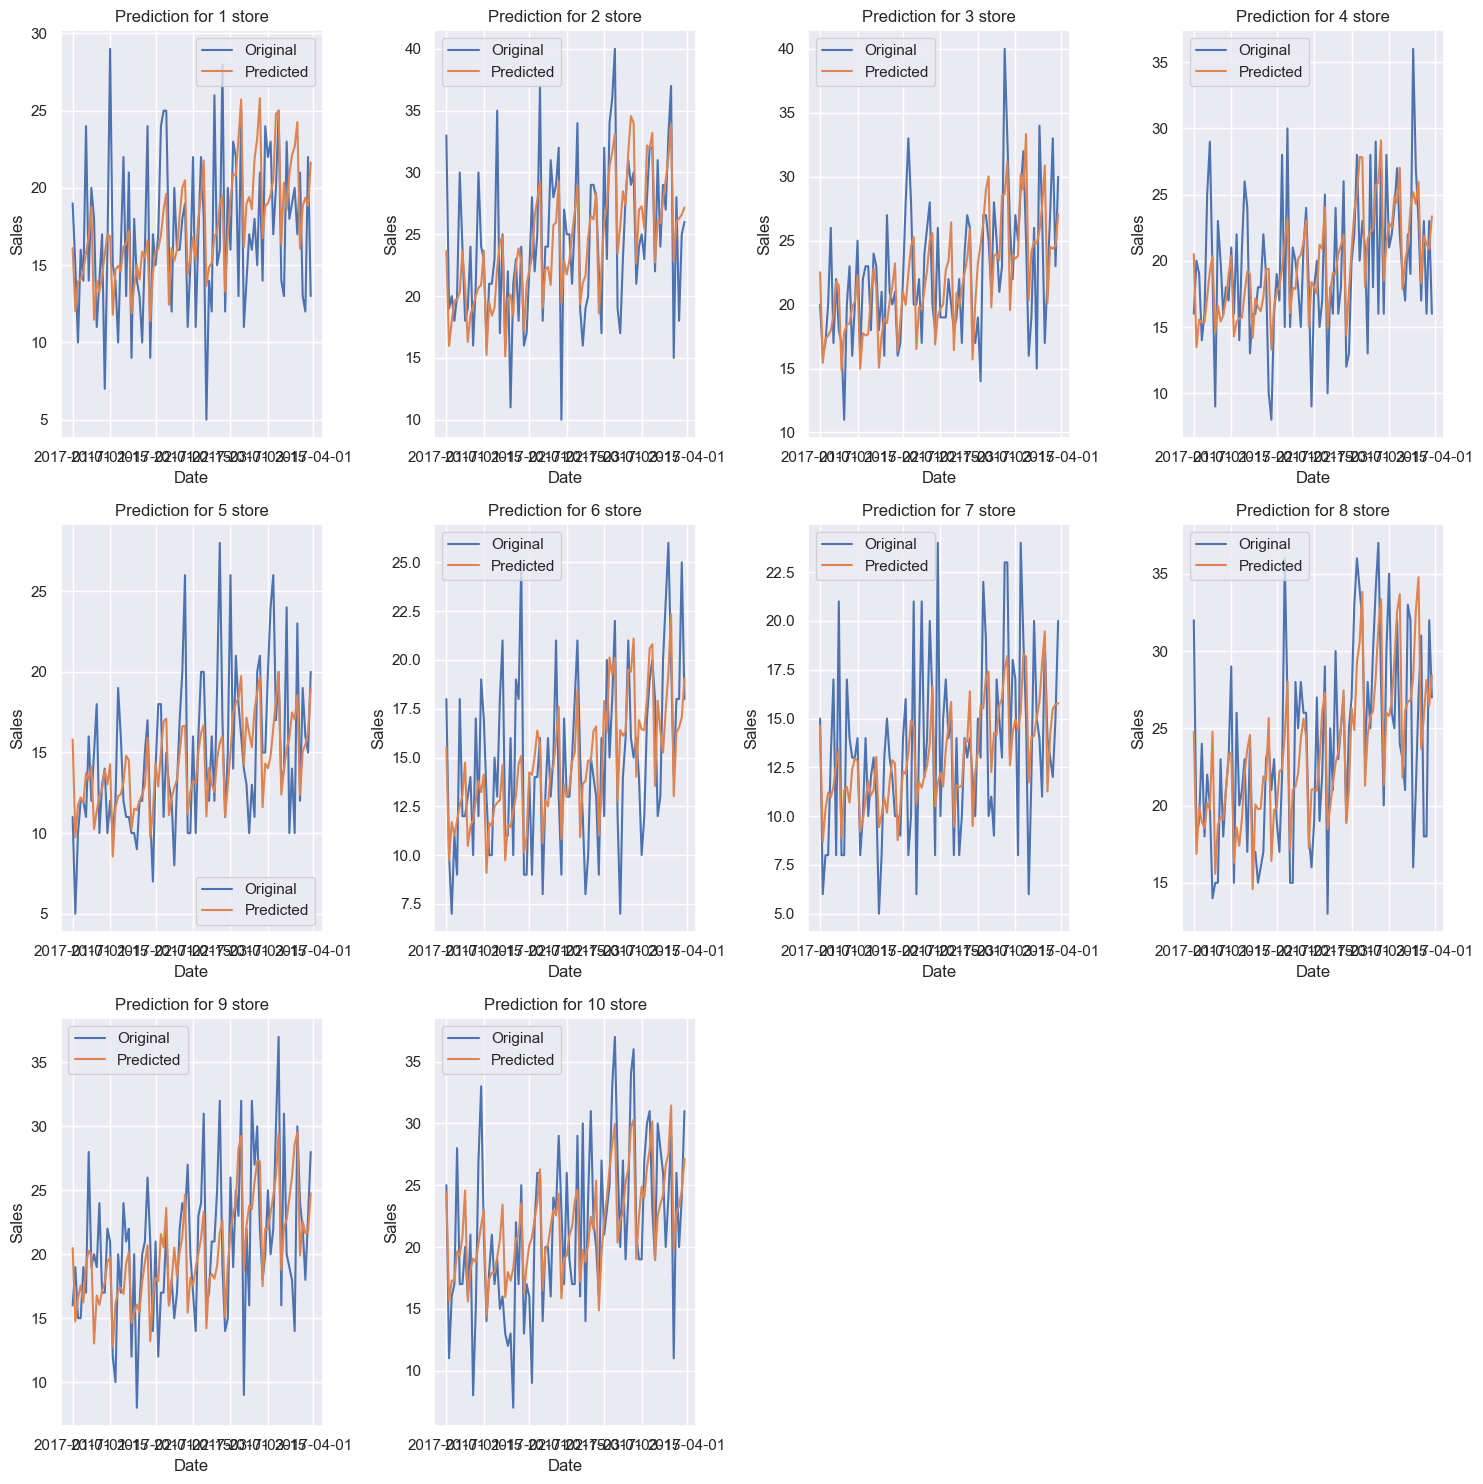

In [97]:
train2 = pd.read_csv("train.csv",parse_dates=["date"])
val2 = train2.loc[(train2["date"] >= "2017-01-01") & (train2["date"] < "2017-04-01"), :]
val2["Prediction"] = np.expm1(y_pred_val)

def observing_results_plot(dataframe, item=2):
    plt.figure(figsize=(15,15))
    stores = dataframe["store"].unique()
    for ax, store_id in enumerate(stores):
        data = dataframe[(dataframe["store"] == store_id) & (dataframe["item"] == item)]
        plt.subplot(3,4, ax+1)
        plt.title("Prediction for {} store".format(store_id))
        plt.plot(data["date"], data["sales"], label="Original")
        plt.plot(data["date"], data["Prediction"], label="Predicted")
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
    plt.tight_layout()
    plt.show()


observing_results_plot(val2, item=1)

## Final Model

In [99]:
train = df.loc[~df.sales.isna()]
Y_train = train["sales"]
X_train = train[feature_imp[feature_imp["Value"]>=0.002]["Feature"]]

test = df.loc[df.sales.isna()]
X_test = test[feature_imp[feature_imp["Value"]>=0.002]["Feature"]]

In [100]:
final_model = XGBRegressor(**study.best_params).fit(X_train, Y_train)

test_preds = model.predict(X_test)

submission_df = test.loc[:, ["id","sales"]]
submission_df["sales"] = np.expm1(test_preds)

submission_df.head()

,id,sales
0,0.000,12.699
1,1.000,15.451
2,2.000,15.432
3,3.000,14.274
4,4.000,15.812


In [101]:
submission_df["id"] = submission_df["id"].astype(int)
submission_df.head()

,id,sales
0,0,12.699
1,1,15.451
2,2,15.432
3,3,14.274
4,4,15.812


In [102]:
submission_df.to_csv("submission_demand_2.csv", index = False)